In [122]:
# 라이브러리 불러오기
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision import transforms
import torchaudio
import pandas as pd
import torch
import torch.nn as nn

In [123]:
import torch
import subprocess

def GPU():
    if torch.cuda.is_available() == True:
        device = 'cuda'
        templist = [1, 2, 3]
        templist = torch.FloatTensor(templist).to(device)
        print("Cuda torch working : ", end="")
        print(templist.is_cuda)
        print("current device no. : ", end="")
        print(torch.cuda.current_device())
        print("GPU device count : ", end="")
        print(torch.cuda.device_count())
        print("GPU name : ", end="")
        print(torch.cuda.get_device_name(0))
        print("device : ", device)
        # Execute the nvidia-smi command using subprocess
        try:
            output = subprocess.check_output(['nvidia-smi']).decode('utf-8')
            print("nvidia-smi output:")
            print(output)
        except (subprocess.CalledProcessError, FileNotFoundError) as e:
            print("Error executing nvidia-smi command:", str(e))
    elif torch.backends.mps.is_available() == True:
        print("Apple device detected\nActivating Apple Silicon GPU")
        device = torch.device("mps")
    else:
        print("cant use gpu , activating cpu")
        device = 'cpu'

    return device
device = GPU()
print(device)

Apple device detected
Activating Apple Silicon GPU
mps


In [124]:
# To use 3 channel Resnet
class MonoToColor(nn.Module):
    def __init__(self, num_channels=3):
        super(MonoToColor, self).__init__()
        self.num_channels = num_channels

    def forward(self, tensor):
        return tensor.repeat(self.num_channels, 1, 1)

In [125]:
# Dataset 클래스 정의
import os
import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset

class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        
        # Directly assign class IDs without filtering on selected labels
        self.annotations['classID'] = self.annotations['class'].astype('category').cat.codes

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, torch.tensor(label, dtype=torch.long)

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.target_sample_rate:
            signal = signal[:, :self.target_sample_rate]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.target_sample_rate:
            num_missing_samples = self.target_sample_rate - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        fold = self.annotations.iloc[index, 5]
        file_name = self.annotations.iloc[index, 0]
        #audio_sample_path = os.path.join(self.audio_dir, fold, file_name)
        audio_sample_path = os.path.join("../../../../../검은 상자/@CODE",self.audio_dir, fold, file_name)
        return audio_sample_path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]

In [126]:
# 데이터셋 및 데이터 로더 설정
import pandas as pd

# Load the dataset
ANNOTATIONS_FILE = '/Volumes/검은 상자/@CODE/dataset2/data2.csv'
temp_csv = pd.read_csv('/Volumes/검은 상자/@CODE/dataset2/data2.csv')
temp_csv.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,children_cut_0000.wav,540970,259.733605,261.733605,1,children,0,children
1,children_cut_0001.wav,548447,3183.482744,3185.482744,1,children,0,children
2,children_cut_0002.wav,883691,237.423311,239.423311,1,children,0,children
3,children_cut_0003.wav,661176,1907.488526,1909.488526,1,children,0,children
4,children_cut_0004.wav,969140,3735.553537,3737.553537,1,children,0,children
5,children_cut_0005.wav,742221,684.140272,686.140272,1,children,0,children
6,children_cut_0006.wav,776059,2565.087755,2567.087755,1,children,0,children
7,children_cut_0007.wav,265473,3600.593900,3602.593900,1,children,0,children
8,children_cut_0008.wav,582832,1581.066780,1583.066780,1,children,0,children
9,children_cut_0009.wav,891737,1144.900794,1146.900794,1,children,0,children


In [127]:
import pandas as pd

# Assuming you have the ANNOTATIONS_FILE dataframe
# You can use the value_counts() function on the 'class' column
label_counts = temp_csv['class'].value_counts()

# Display the counts of files for each label in a tabular format
print(label_counts)

children        1000
nothing2        1000
drilling        1000
engine          1000
siren           1000
gunshot         1000
aircon          1000
jackhammer      1000
carhorn         1000
glass           1000
nock            1000
street_music    1000
dog_bark        1000
nothing1        1000
Name: class, dtype: int64


In [128]:
random = 1 # 1== random,  0 == fix seed

if random == 0:
    import random
    import numpy as np

    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [129]:
AUDIO_DIR = 'dataset2'

In [130]:
SAMPLE_RATE = 22050
BATCH_SIZE = 1
NUM_WORKERS = 0
PIN_MEMORY = True if torch.cuda.is_available() else False

In [131]:
class MinMaxNormalize(nn.Module):
    def __init__(self, min_val=None, max_val=None):
        super(MinMaxNormalize, self).__init__()
        self.min_val = min_val
        self.max_val = max_val

    def forward(self, tensor):
        if self.min_val is None or self.max_val is None:
            min_val = torch.min(tensor)
            max_val = torch.max(tensor)
        else:
            min_val = self.min_val
            max_val = self.max_val
        
        normalized_tensor = (tensor - min_val) / (max_val - min_val)
        return normalized_tensor

In [132]:
transformation = transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=40),# higher the better but more complex. For talking we use 128, for sound effect, about 40.
    torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80),
    MinMaxNormalize(),
    MonoToColor()
])

In [133]:
usd = UrbanSoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, transformation, SAMPLE_RATE)

In [134]:
# 데이터셋 분리
dataset_size = len(usd)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(usd, [train_size, val_size, test_size])

# 데이터 로더 생성
train_loader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

test_loader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)


In [135]:
ANNOTATIONS_FILE

'/Volumes/검은 상자/@CODE/dataset2/data2.csv'

In [136]:
usd

In [137]:
num_labels = len(usd.annotations['classID'].unique())
num_labels

14

In [138]:
# ResNet18 모델 설정
model = resnet18(pretrained=False)
# Change the output neurons of the model
model.fc = nn.Linear(512,num_labels) 
# Use multiple GPUs if available
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)
model = model.to(device)

/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [139]:
# 손실함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [140]:
# 학습률 스케줄러 설정
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train func 2 (more normal)

In [141]:
from tqdm import tqdm

def train_model2(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    global best_acc
    global train_loss_list, val_loss_list, train_acc_list, val_acc_list
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    best_acc = 0.0
    best_model_counter = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss_train = 0.0
        running_corrects_train = 0

        for inputs, labels in tqdm(dataloaders['train']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss_train += loss.item() * inputs.size(0)
            running_corrects_train += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss_train = running_loss_train / dataset_sizes['train']
        epoch_acc_train = running_corrects_train.float() / dataset_sizes['train']

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        # Append to the train lists
        train_loss_list.append(epoch_loss_train)
        train_acc_list.append(epoch_acc_train.item())

        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_loss_val = 0.0
        running_corrects_val = 0

        for inputs, labels in tqdm(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)

        epoch_loss_val = running_loss_val / dataset_sizes['val']
        epoch_acc_val = running_corrects_val.float() / dataset_sizes['val']

        print('Validation Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))

        # Append to the validation lists
        val_loss_list.append(epoch_loss_val)
        val_acc_list.append(epoch_acc_val.item())

        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
            best_model_counter += 1
            formatted_counter = str(best_model_counter).zfill(3)
            model_save_path = os.path.join("models", f"Model2_{formatted_counter}.pth")
            torch.save(model.state_dict(), model_save_path)
            print(f'Best model saved at {model_save_path}')

    print('Best Validation Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# This is the updated function
train_model2

<function __main__.train_model2(model, dataloaders, criterion, optimizer, scheduler, num_epochs)>

In [142]:
import copy
nb_epochs = 1000
# 모델 훈련 시작
dataloaders = {"train": train_loader, "val": val_loader}
# define dataset_sizes
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

best_model = train_model2(model, dataloaders, criterion, optimizer, scheduler, num_epochs=nb_epochs)

Epoch 1/1000
----------


100%|██████████| 11200/11200 [13:40<00:00, 13.66it/s]


Train Loss: 1.2502 Acc: 0.5668


100%|██████████| 1400/1400 [00:47<00:00, 29.32it/s]


Validation Loss: 2.9901 Acc: 0.1607
Best model saved at models/Model2_001.pth
Epoch 2/1000
----------


100%|██████████| 11200/11200 [14:07<00:00, 13.21it/s]


Train Loss: 0.6591 Acc: 0.7684


100%|██████████| 1400/1400 [00:47<00:00, 29.37it/s]


Validation Loss: 4.1404 Acc: 0.2579
Best model saved at models/Model2_002.pth
Epoch 3/1000
----------


100%|██████████| 11200/11200 [14:00<00:00, 13.33it/s]


Train Loss: 0.4432 Acc: 0.8495


100%|██████████| 1400/1400 [00:47<00:00, 29.37it/s]


Validation Loss: 5.0394 Acc: 0.1621
Epoch 4/1000
----------


100%|██████████| 11200/11200 [13:55<00:00, 13.40it/s]


Train Loss: 0.3191 Acc: 0.8879


100%|██████████| 1400/1400 [00:47<00:00, 29.28it/s]


Validation Loss: 4.9808 Acc: 0.1921
Epoch 5/1000
----------


100%|██████████| 11200/11200 [13:43<00:00, 13.61it/s]


Train Loss: 0.2313 Acc: 0.9205


100%|██████████| 1400/1400 [00:48<00:00, 28.76it/s]


Validation Loss: 9.1016 Acc: 0.1771
Epoch 6/1000
----------


100%|██████████| 11200/11200 [13:44<00:00, 13.59it/s]


Train Loss: 0.1595 Acc: 0.9451


100%|██████████| 1400/1400 [00:47<00:00, 29.28it/s]


Validation Loss: 7.8587 Acc: 0.1857
Epoch 7/1000
----------


100%|██████████| 11200/11200 [13:46<00:00, 13.56it/s]


Train Loss: 0.1144 Acc: 0.9608


100%|██████████| 1400/1400 [00:47<00:00, 29.23it/s]


Validation Loss: 9.2662 Acc: 0.2693
Best model saved at models/Model2_003.pth
Epoch 8/1000
----------


100%|██████████| 11200/11200 [14:00<00:00, 13.32it/s]


Train Loss: 0.0257 Acc: 0.9936


100%|██████████| 1400/1400 [00:47<00:00, 29.43it/s]


Validation Loss: 8.4813 Acc: 0.2914
Best model saved at models/Model2_004.pth
Epoch 9/1000
----------


100%|██████████| 11200/11200 [13:37<00:00, 13.70it/s]


Train Loss: 0.0048 Acc: 0.9997


100%|██████████| 1400/1400 [00:47<00:00, 29.40it/s]


Validation Loss: 10.1219 Acc: 0.3164
Best model saved at models/Model2_005.pth
Epoch 10/1000
----------


100%|██████████| 11200/11200 [13:44<00:00, 13.58it/s]


Train Loss: 0.0011 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.32it/s]


Validation Loss: 9.4004 Acc: 0.2929
Epoch 11/1000
----------


100%|██████████| 11200/11200 [13:45<00:00, 13.57it/s]


Train Loss: 0.0003 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.18it/s]


Validation Loss: 11.5614 Acc: 0.3229
Best model saved at models/Model2_006.pth
Epoch 12/1000
----------


100%|██████████| 11200/11200 [13:27<00:00, 13.86it/s]


Train Loss: 0.0001 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.58it/s]


Validation Loss: 10.3397 Acc: 0.3300
Best model saved at models/Model2_007.pth
Epoch 13/1000
----------


100%|██████████| 11200/11200 [13:08<00:00, 14.21it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.57it/s]


Validation Loss: 11.2590 Acc: 0.2914
Epoch 14/1000
----------


100%|██████████| 11200/11200 [13:05<00:00, 14.25it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.59it/s]


Validation Loss: 10.1373 Acc: 0.3843
Best model saved at models/Model2_008.pth
Epoch 15/1000
----------


100%|██████████| 11200/11200 [13:06<00:00, 14.24it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.53it/s]


Validation Loss: 11.8182 Acc: 0.3036
Epoch 16/1000
----------


100%|██████████| 11200/11200 [13:05<00:00, 14.26it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.60it/s]


Validation Loss: 12.3275 Acc: 0.3443
Epoch 17/1000
----------


100%|██████████| 11200/11200 [13:07<00:00, 14.22it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.61it/s]


Validation Loss: 11.2495 Acc: 0.3421
Epoch 18/1000
----------


100%|██████████| 11200/11200 [13:06<00:00, 14.24it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.59it/s]


Validation Loss: 10.0885 Acc: 0.3679
Epoch 19/1000
----------


100%|██████████| 11200/11200 [13:05<00:00, 14.25it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.74it/s]


Validation Loss: 9.6334 Acc: 0.3379
Epoch 20/1000
----------


100%|██████████| 11200/11200 [13:07<00:00, 14.22it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.59it/s]


Validation Loss: 10.7611 Acc: 0.3421
Epoch 21/1000
----------


100%|██████████| 11200/11200 [13:08<00:00, 14.21it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.60it/s]


Validation Loss: 11.7097 Acc: 0.3493
Epoch 22/1000
----------


100%|██████████| 11200/11200 [13:07<00:00, 14.22it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.69it/s]


Validation Loss: 11.9538 Acc: 0.3286
Epoch 23/1000
----------


100%|██████████| 11200/11200 [13:06<00:00, 14.23it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.51it/s]


Validation Loss: 13.7118 Acc: 0.2971
Epoch 24/1000
----------


100%|██████████| 11200/11200 [13:06<00:00, 14.24it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.60it/s]


Validation Loss: 13.2624 Acc: 0.2464
Epoch 25/1000
----------


100%|██████████| 11200/11200 [13:07<00:00, 14.22it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.56it/s]


Validation Loss: 11.6208 Acc: 0.3736
Epoch 26/1000
----------


100%|██████████| 11200/11200 [13:06<00:00, 14.24it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.53it/s]


Validation Loss: 10.2815 Acc: 0.3900
Best model saved at models/Model2_009.pth
Epoch 27/1000
----------


100%|██████████| 11200/11200 [13:08<00:00, 14.21it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.61it/s]


Validation Loss: 10.3822 Acc: 0.3993
Best model saved at models/Model2_010.pth
Epoch 28/1000
----------


100%|██████████| 11200/11200 [13:08<00:00, 14.21it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.62it/s]


Validation Loss: 10.5380 Acc: 0.3643
Epoch 29/1000
----------


100%|██████████| 11200/11200 [13:08<00:00, 14.20it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.60it/s]


Validation Loss: 11.8579 Acc: 0.3993
Epoch 30/1000
----------


100%|██████████| 11200/11200 [13:07<00:00, 14.22it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.53it/s]


Validation Loss: 10.4156 Acc: 0.3621
Epoch 31/1000
----------


100%|██████████| 11200/11200 [13:07<00:00, 14.23it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.56it/s]


Validation Loss: 11.1138 Acc: 0.3807
Epoch 32/1000
----------


100%|██████████| 11200/11200 [13:07<00:00, 14.22it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.57it/s]


Validation Loss: 10.7444 Acc: 0.3586
Epoch 33/1000
----------


100%|██████████| 11200/11200 [13:07<00:00, 14.23it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.61it/s]


Validation Loss: 11.4409 Acc: 0.3614
Epoch 34/1000
----------


100%|██████████| 11200/11200 [13:08<00:00, 14.21it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.63it/s]


Validation Loss: 10.0517 Acc: 0.3700
Epoch 35/1000
----------


100%|██████████| 11200/11200 [13:07<00:00, 14.21it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.62it/s]


Validation Loss: 12.6612 Acc: 0.3036
Epoch 36/1000
----------


100%|██████████| 11200/11200 [13:08<00:00, 14.21it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.50it/s]


Validation Loss: 11.6283 Acc: 0.3721
Epoch 37/1000
----------


100%|██████████| 11200/11200 [13:07<00:00, 14.22it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.68it/s]


Validation Loss: 12.5423 Acc: 0.3314
Epoch 38/1000
----------


100%|██████████| 11200/11200 [13:09<00:00, 14.19it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.53it/s]


Validation Loss: 10.8835 Acc: 0.3607
Epoch 39/1000
----------


100%|██████████| 11200/11200 [13:08<00:00, 14.20it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.42it/s]


Validation Loss: 11.6193 Acc: 0.3093
Epoch 40/1000
----------


100%|██████████| 11200/11200 [13:06<00:00, 14.24it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.49it/s]


Validation Loss: 10.4044 Acc: 0.3300
Epoch 41/1000
----------


100%|██████████| 11200/11200 [13:09<00:00, 14.19it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.47it/s]


Validation Loss: 11.3801 Acc: 0.3357
Epoch 42/1000
----------


100%|██████████| 11200/11200 [13:11<00:00, 14.16it/s]


Train Loss: 0.0000 Acc: 1.0000


100%|██████████| 1400/1400 [00:47<00:00, 29.46it/s]


Validation Loss: 12.7452 Acc: 0.2936
Epoch 43/1000
----------


 22%|██▏       | 2509/11200 [03:01<10:28, 13.83it/s]


KeyboardInterrupt: 

In [143]:
train_acc_list = torch.tensor(train_acc_list).detach().cpu()

In [144]:
val_acc_list = torch.tensor(val_acc_list).detach().cpu()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (42,)

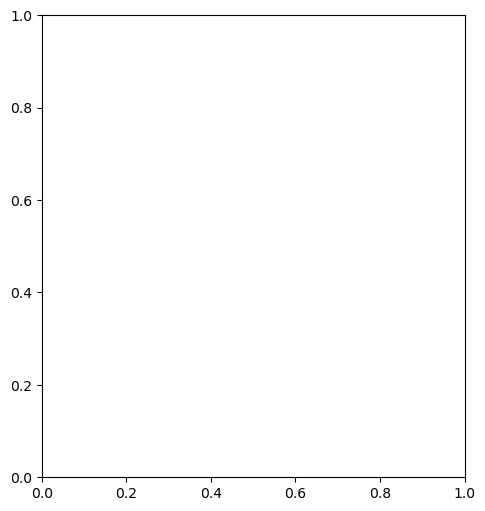

In [147]:
# Plot training and validation loss and accuracy
# Move tensors to CPU
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, nb_epochs + 1), train_loss_list, label='Train')
plt.plot(range(1, nb_epochs + 1), val_loss_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, nb_epochs + 1), train_acc_list, label='Train')
plt.plot(range(1, nb_epochs + 1), val_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [148]:
# 모델 평가 함수 정의
def test_model(model, test_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on test images: {100 * correct / total}%')


In [149]:
# 훈련 및 평가
test_model(best_model, test_loader, device)

100%|██████████| 1400/1400 [00:49<00:00, 28.19it/s]

Accuracy of the model on test images: 26.071428571428573%
